In [1]:
#set drive and import
drive_path = '/Volumes/Brain2016'

import os
import numpy as np
import pandas as pd
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_data():
    #get the experiment data
    # When downloading 3D connectivity data volumes, what resolution do you want (in microns)?  
    # Options are: 10, 25, 50, 100
    resolution_um=25 #do not change

    # The manifest file is a simple JSON file that keeps track of all of
    # the data that has already been downloaded onto the hard drives.
    # If you supply a relative path, it is assumed to be relative to your
    # current working directory.
    manifest_file = os.path.join(drive_path, "MouseConnectivity","manifest.json")

    mcc = MouseConnectivityCache(manifest_file=manifest_file, resolution=resolution_um)

    # open up a pandas dataframe of all of the experiments
    all_experiments = mcc.get_experiments(dataframe=True)
    return(mcc,all_experiments)

In [3]:
def get_ont(mcc):
    #set up ontology & summary naming 
    ontology = mcc.get_ontology()
    names = mcc.get_structures()
    grey = ontology['grey']
    return(ontology,names,grey)

In [4]:
#define my parameters (regions, thresholds): global parameters/initializations
rnames = ['LO','MO']
settings = ['one','two','three']
#visualization params
proj_thresh = 5 #threshold for plotting projection volume by region

In [5]:
#make a dictionary to read structure abbreviations
def make_dict(names):
    values = names['acronym'].values 
    values2 = names['name'].values 
    keys = names['acronym'].index
    ac_d = dict(zip(keys, values))
    name_d = dict(zip(keys, values2))
    return name_d, ac_d

In [6]:
#define my parameters: variable parameters
def get_params(setting):
    regions = {}
    #try a range of settings: loose, middle, strict
    if setting == 'one':
        include = [['ORBl','AIv','AId'],['ORBm','ORBvl']]
        exclude = [[],['ORBl']] #regions to exclude if this is the second most voluminous site after the target:      
        #pick which experiments to throw out
        #off the bat, throw out anything that meets these criteria:
        bad_vol = .55 #cut off for not enough injected into my ROI
        #maximum correlation of injection area between the two different regions you're looking at
        corr_max = 0.02
    elif setting == 'two':
        include = [['ORBl','AIv','AId'],['ORBm','ORBvl']]
        exclude = [[],['ORBl']]
        bad_vol = .67 
        corr_max = 0
        diff_thresh=0.05
    elif setting == 'three':
        include = [['ORBl'],['ORBm']]
        exclude = [[],['ORBl']]
        bad_vol = .6 
        corr_max = 0
        diff_thresh=0.1
    for z,i in enumerate(rnames):
            i = {}
            i['include'] = include[z]
            i['exclude'] = exclude[z]
            regions[rnames[z]] = i
    diff_thresh=0.1
    return regions,bad_vol,corr_max,diff_thresh

In [7]:
#first get all the ORBl & ORBm expts
def get_your_experiments(regions,ontology,mcc):
    for k,v in regions.iteritems():
        temp = mcc.get_experiments(injection_structure_ids= ontology[v['include']]['id'],dataframe = True)
        temp2 = mcc.get_experiments(injection_structure_ids= ontology[v['include']]['id'],dataframe = True,cre=False)
        regions[k]['experiments'] = temp.id.values
        regions[k]['wt'] = temp2.id.values
        print(k + ": %d experiments" % len(temp.id.values))
    return regions

In [8]:
#plot how much of the projection was in each region of the brain for all experiments 
def make_table_by_region(regions,proj_thresh,mcc,grey,name_d):
    for k,v in regions.iteritems():
        #v['experiments'] is all experiments
        columns_to_display = ['struct_name','normalized_projection_volume']
        inj = mcc.get_structure_unionizes(v['df_injection_volumes'].index, structure_ids = grey['id'],is_injection=False,hemisphere_ids=[3])
        grouped = inj.groupby(['structure_id'],as_index=True).mean()
        grouped['struct_name']= grouped.index
        grouped['struct_name'].replace(name_d, inplace=True)
        d = grouped.sort_values(by='normalized_projection_volume',ascending=False)
        d = d[columns_to_display][d['normalized_projection_volume']>proj_thresh] 
        d=d[6:21]
        plot_proj_bar(d,start_fig=0,xs='struct_name',ys='normalized_projection_volume',ylab="# normalized projection volume",title=("Projection sites targeted by " + k))
        regions[k]['df_projection_volumes'] = grouped[columns_to_display]
    return regions

In [9]:
def make_table_by_proportion_in(regions,mcc,ontology,ac_d,bad_vol):
    for k,v in regions.iteritems():
        columns_to_display = ['experiment_id','normalized_projection_volume']
        inj = mcc.get_structure_unionizes(v['experiments'], is_injection=True, hemisphere_ids=[3])
        grouped = inj[inj['structure_id'].isin(ontology[v['include']]['id'])]
        grouped = grouped[columns_to_display].groupby(['experiment_id']).sum()
        #grouped = grouped['normalized_projection_volume'].sort_values()
        #grouped['index'] = grouped.index
        #plot_proj_bar(grouped,start_fig=0,xs='index',ys='normalized_projection_volume',ylab="# normalized projection volume",title=("Proportion injections in " + k))
        ok = get_inj_stuff(v,ontology)
        columns_to_display = ['structure_id','experiment_id','normalized_projection_volume']
        grouped2 = inj[columns_to_display].sort_values(by = ['experiment_id','normalized_projection_volume'],ascending=False)
        grouped2['struct_name']= grouped2['structure_id'].copy()
        grouped2['struct_name'].replace(ac_d, inplace=True)
        grouped2 = grouped2[~grouped2['struct_name'].isin(ok)]
        grouped2 = grouped2.groupby('experiment_id').first()
        grouped2['good_vol'] = grouped.normalized_projection_volume.values
        grouped2=grouped2.rename(columns = {'normalized_projection_volume':'bad_vol'})
        grouped2['ratio'] = grouped2['bad_vol']/grouped2['good_vol']
        grouped2 =grouped2[grouped['normalized_projection_volume']>bad_vol]
        grouped2 = grouped2[~grouped2['struct_name'].isin(v['exclude'])]
        columns_to_display = ['good_vol','bad_vol','ratio','struct_name']
        grouped2 = grouped2[columns_to_display]
        #grouped2 = grouped2.sort_values(by = 'good_vol')
        regions[k]['df_injection_volumes'] = grouped2
    return regions

In [10]:
def compare_proj(regions,ndf,diff_thresh):
    d =  ndf[['struct_name','diffs']][np.abs(ndf['diffs'])>diff_thresh] 
    plot_proj_bar(d,start_fig=0,xs='struct_name',ys='diffs',ylab="diff normalized projection volume",title="targets diff LO - MO")

In [11]:
def plot_proj_bar(d,start_fig,xs, ys,ylab,title):
    fig,ax=plt.subplots(figsize=(12,6))
    y = d[ys]
    x = d[xs]
    y[start_fig:].plot(kind='bar')
    ax.set_xticklabels(x[start_fig:])
    ax.set_title(ylab);
    ax.set_ylabel(title);
    fig.tight_layout() #this keeps the x-labels from getting cut off

In [12]:
def simple_proj_corr(regions):
    for k,v in regions.iteritems():
        #normalize to grey matter
        norm = (v['df_projection_volumes'].normalized_projection_volume[v['df_projection_volumes'].index==8])
        v['df_projection_volumes'].normalized_projection_volume = (v['df_projection_volumes'].normalized_projection_volume/norm.values)
    ks = regions.keys()
    ndf = regions[ks[0]]['df_projection_volumes']
    rdf = regions[ks[1]]['df_projection_volumes']
    if (np.all(ndf.index.isin(rdf.index))) and np.all(rdf.index.isin(ndf.index)):
        print(np.sum(ndf.index-rdf.index))
    else:
        print'modify code'
    ndf['comp_vol'] = rdf.normalized_projection_volume.values
    ndf['diffs']=ndf.normalized_projection_volume-ndf.comp_vol
    ndf = ndf.sort_values(by='diffs')
    return ndf

In [13]:
def get_inj_stuff(v,ontology):
    good = np.array
    for j in (v['include']):
        a = ontology.df[ontology.df.acronym.str.contains(j)] 
        good = np.insert(good,0, a['acronym'].values)
    if any('AI' in s for s in v['include']): good = np.insert(good,0,'AI')
    ok = np.insert(good,0,['root','CTX','grey','CTXpl','Isocortex','CH','ORB'])
    return ok

In [14]:
#make masks for LO & MO
def get_brain_masks(regions, mcc,ontology):
    for k,v in regions.iteritems():
        good_vo = np.zeros([528, 320, 456])
        #print(good_vo.sum())
        for j in ontology[v['include']]['id']:
            good_vol, _ = mcc.get_structure_mask(j)
            good_vo = good_vo + good_vol
            #print(good_vo.sum())
        regions[k]['brain_mask']= np.where(good_vo)
    return regions

In [15]:
#see where injections were in LO/MO
def get_masks(regions,mcc): 
    mask_area = {}
    for k,k2 in regions.iteritems():#loop through masks    
        mask = k     
        d = {}
        for kk,kk2 in regions.iteritems(): #loop through experiments by region
            v = np.array(kk2['df_injection_volumes'].index)
            df = pd.DataFrame(columns = v)
            for i,experiment_id in enumerate(v):
                pd2, _ = mcc.get_injection_density(experiment_id)
                df[experiment_id] = pd2[k2['brain_mask']]
            d[kk] = df #mask name,area name
        mask_area[mask] = d           
    return mask_area

In [16]:
def get_corr(mask_area):
    Dict4 = {}
    for mask,area in mask_area.iteritems(): #for each mask
        ks = area.keys()
        v0 = area[ks[0]]
        v1 = area[ks[1]]
        name = (ks[0]+'v' + ks[1] +"mask" + mask)
        cols = v0.columns
        rows = v1.columns
        n = [len(cols),len(rows)]
        a = np.empty(n)
        df_arr = pd.DataFrame(columns=cols)
        for ii in cols:
            c = np.empty(n[1])
            j = -1
            for jj in rows:
                j = j + 1
                b = np.corrcoef(v0[ii].values, v1[jj].values)
                c[j]=(b[0,1])
            df_arr[ii] = pd.Series(c)
        df_arr.set_index(rows,inplace=True)
        Dict4[name] = df_arr   
    return Dict4

In [17]:
#find the index that is most highly correlated
def find_corr_inj(Dict4,corr_max):
    cols = ('max','col','row')
    df2 = pd.DataFrame(columns = cols)
    i = 0
    for k,df in Dict4.iteritems(): #columns are LO, rows MO
        mm = df.max().max()
        if (np.isnan(mm)) or mm<corr_max:
            max_corr = -1 #exit loop
            expts = []
            break
        colmax = df.max()[df.max() == df.max(axis=1).max()].index
        rmax = (df[colmax].idxmax().values).astype(dtype='int64')
        st = [mm, colmax[0], rmax[0]]
        df2.loc[i]=st
        i = i + 1
    if np.isnan(mm)==False and mm>corr_max:
        max_corr = df2['max'].max()
        ins = df2['max'].idxmax()
        expts = df2.loc[ins, 'col':'row']
        expts = expts.tolist()
    return expts,max_corr

In [18]:
#check the fraction correct inj. volume between the two; delete the one that has the least
def id_expts(regions,expts):
    val=[]
    wts = []
    print(expts)
    for k,v in regions.iteritems():
        wts.append(v['wt'])
    wts = wts[0].tolist()+ wts[1].tolist()
    print(wts)
    for k,v in regions.iteritems(): #where volume dataframes are for expt
        c = v['df_injection_volumes']['good_vol']
        a = c[c.index.isin(expts)]
        val.append((a.values))
    if np.any(expts in wts):
        if np.all(expts in wts):
            rem = expts[np.argmin(val)]
        else:
            rem = expts[~(expts in wts)] 
    else:
        rem = expts[np.argmin(val)]
    rem = int(rem)
    return rem

In [19]:
def plot_heat(Dict4,regions):
    for k,df in Dict4.iteritems():
        n = (df.shape[0])
        s = (df.values[[np.arange(n)]*2])
        if sum(s) == n:
            (df.values[[np.arange(n)]*2]) = np.nan
        plt.pcolor(df)
        ma = (df.max().max())
        mi = (df.min().min())
        plt.clim(mi, ma)
        plt.colorbar()
        plt.yticks(np.arange(1, len(df.index), 1), df.index)
        plt.xticks(np.arange(1, len(df.columns), 1), df.columns,rotation=90)
        #columns are LO, rows MO
        plt.xlabel(regions[rnames[0]]['include'])
        plt.ylabel(regions[rnames[1]]['include'])
        plt.title(k)
        plt.show()

In [20]:
#update regions,Dict4 to remove expts
def rem_expts(rem,Dict4,regions):
    for k,df in Dict4.iteritems():
        truth = np.array([df.columns==rem])
        if np.any(truth): #LO
            df.drop([rem],inplace=True,axis=1)
        Dict4[k] = (df[~(df.index == rem)]) #MO
    for k,v in regions.iteritems():
        v['experiments'][v['experiments']!=rem]
    return Dict4,regions

In [21]:
def make_backups(*args):
    names = ['c1','c2','c3','c4']
    for i,v in enumerate(args):
        names[i] = v.copy()
    return names[:i+1]

In [22]:
def restore_backups(regionsc,mask_areac,Dict4c):
    Dict4 = Dict4c
    regions = regionsc
    mask_area = mask_areac
    regionsc,mask_areac,Dict4c =make_backups(regions,mask_area,Dict4)
    return regions,mask_area,Dict4,regionsc,mask_areac,Dict4c

In [23]:
def filter_expts(Dict4,regions,corr_max):
    #filter data loop calling functs
    expts,max_corr = find_corr_inj(Dict4,corr_max)
    #loop through and remove most correlated injections until a criteria is met
    while max_corr>corr_max:
        rem = id_expts(regions,expts)
        Dict4,dvols = rem_expts(rem,Dict4,regions)
        expts,max_corr = find_corr_inj(Dict4,corr_max)
    return Dict4,regions

In [24]:
def start(setting,ontology,mcc,ac_d):
    #run prelim functions
    regions,bad_vol,corr_max,diff_thresh = get_params(setting)
    regions = get_your_experiments(regions,ontology,mcc)
    # #make_table_by_region(regions) #turn on if i want to visualize
    regions = make_table_by_proportion_in(regions,mcc,ontology,ac_d,bad_vol)
    regions = get_brain_masks(regions,mcc,ontology)
    mask_area = get_masks(regions,mcc)
    Dict4 = get_corr(mask_area)
    regionsc,mask_areac,Dict4c =make_backups(regions,mask_area,Dict4)
    #check that this worked
    for i in Dict4.itervalues():
        print("average overlap is",np.mean(np.mean(i)))
    plot_heat(Dict4,regions)
    #df_arr.to_pickle('random_df.pkl')
    return Dict4,regions,corr_max,diff_thresh

In [25]:
#now look at projections
def proj_firstpass(regions,mcc,grey,diff_thresh,name_d):
    proj_thresh=0
    regions = make_table_by_region(regions,proj_thresh,mcc,grey,name_d)
    ndf = simple_proj_corr(regions)
    compare_proj(regions,ndf,diff_thresh)

In [26]:
def run_all(settings):
    mcc,all_experiments = get_data()
    ontology,names,grey=get_ont(mcc)
    name_d,ac_d = make_dict(names)
    for setting in settings:
        Dict4,regions,corr_max,diff_thresh = start(setting,ontology,mcc,ac_d)
        Dict4,regions = filter_expts(Dict4,regions,corr_max)
        #check that filtering worked
        for i in Dict4.itervalues():
            print("average overlap is",np.mean(np.mean(i)))
        plot_heat(Dict4,regions)
        proj_firstpass(regions,mcc,grey,diff_thresh,name_d)

LO: 20 experiments
MO: 14 experiments
('average overlap is', -0.005750454155862006)
('average overlap is', -0.001204201218629074)


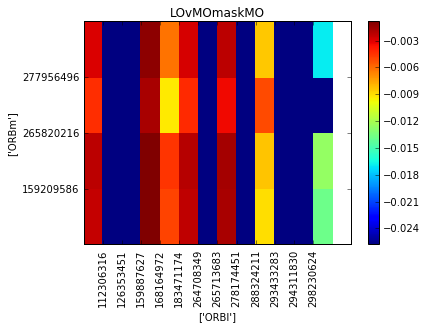

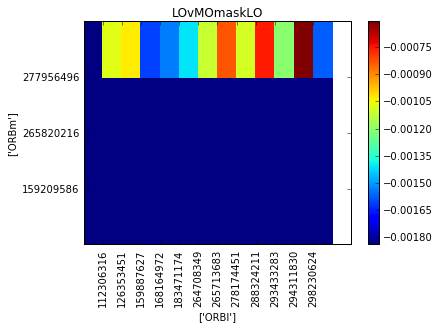

('average overlap is', -0.005750454155862006)
('average overlap is', -0.001204201218629074)


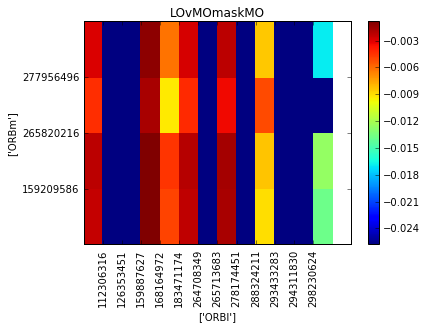

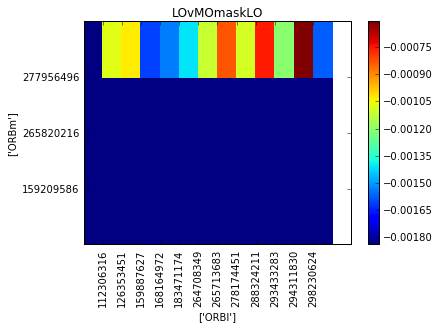

ok
Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', name=u'structure_id', length=643)
LO: 34 experiments
MO: 22 experiments
('average overlap is', -0.010907483369728346)
('average overlap is', 0.009300298607046455)


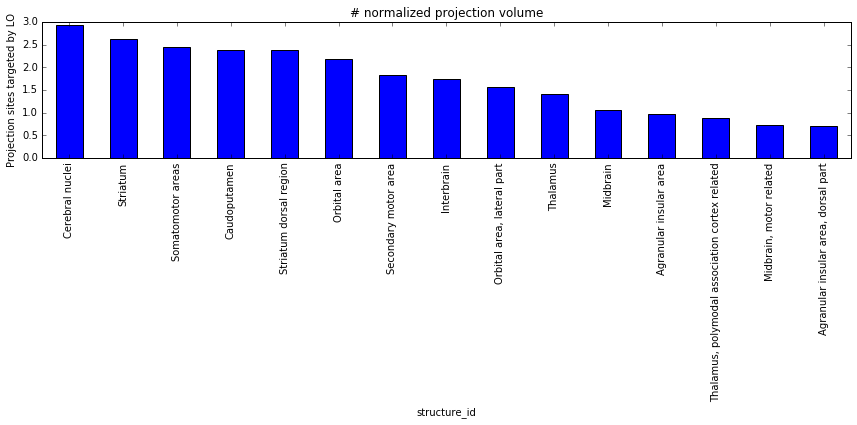

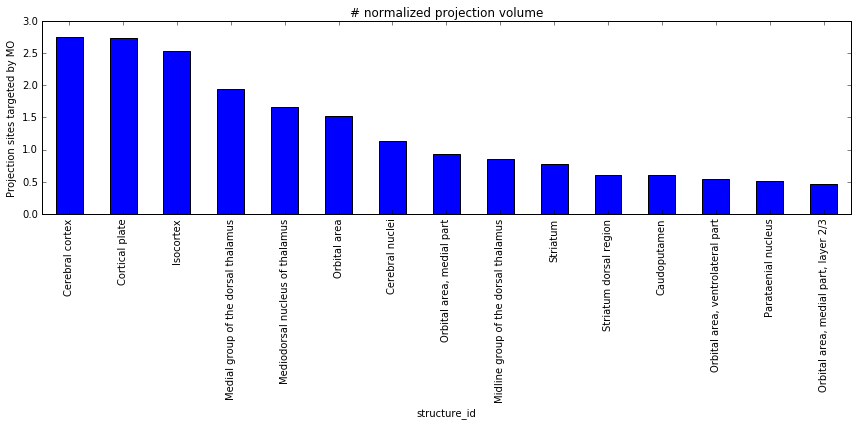

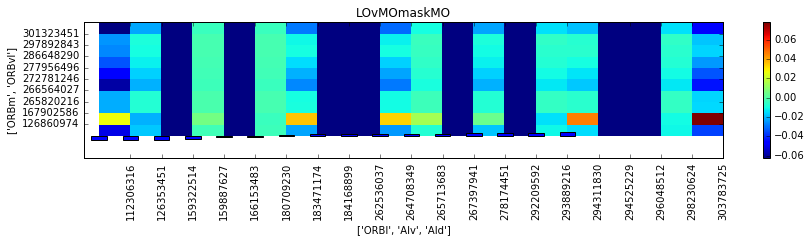

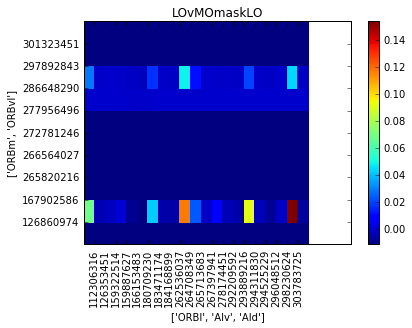

[303783725.0, 167902586.0]
[112596790, 112306316, 180709230, 126860974, 158435116]
('average overlap is', -0.013935115743844283)
('average overlap is', 0.003501384475407996)


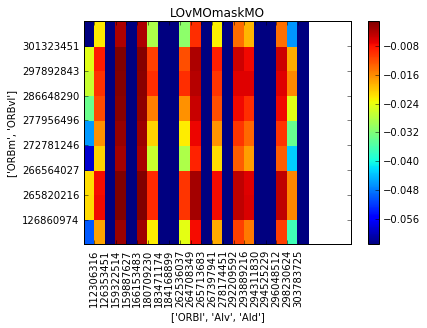

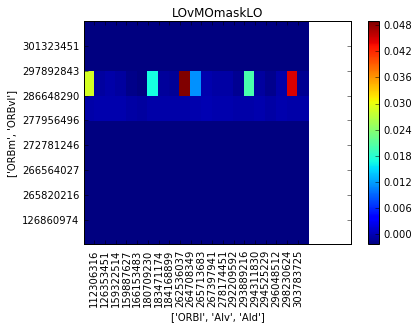

ok
Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', name=u'structure_id', length=643)
LO: 34 experiments
MO: 22 experiments
('average overlap is', -0.012201148994129427)
('average overlap is', 0.006725510127075703)


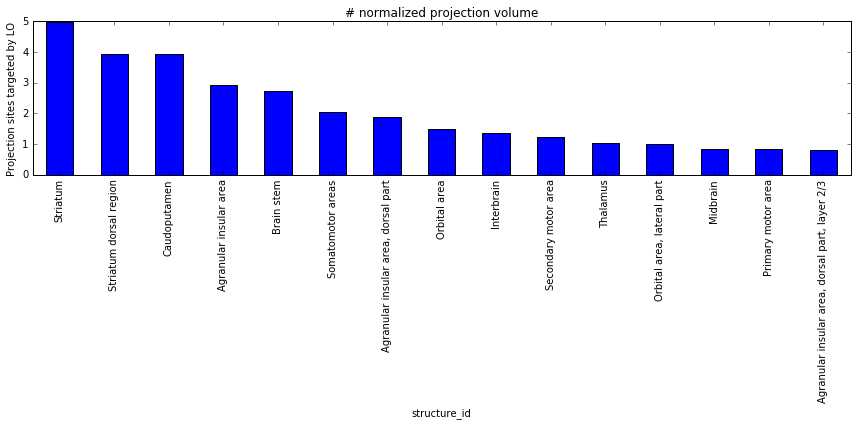

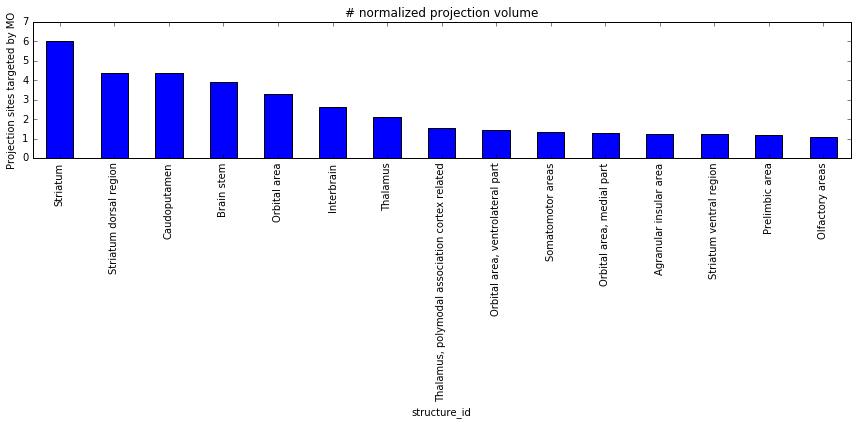

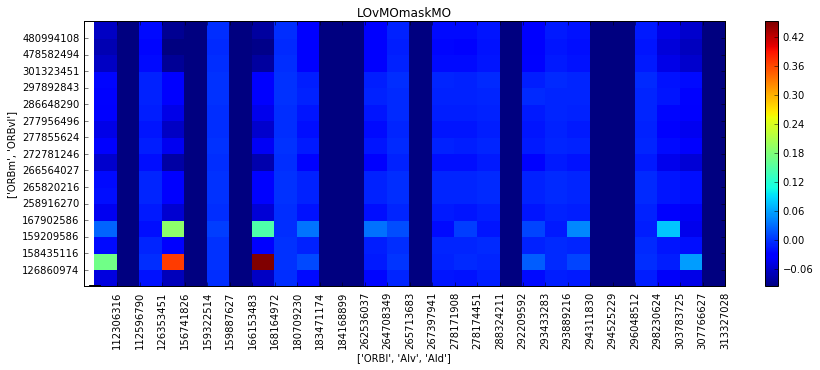

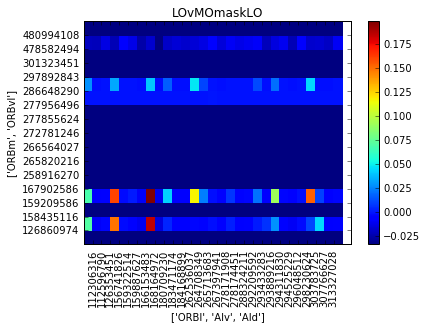

[168164972.0, 158435116.0]
[112596790, 112306316, 180709230, 126860974, 158435116]
[156741826.0, 158435116.0]
[112596790, 112306316, 180709230, 126860974, 158435116]
[156741826.0, 167902586.0]
[112596790, 112306316, 180709230, 126860974, 158435116]
('average overlap is', -0.01399976304802225)
('average overlap is', 0.001742612124905571)


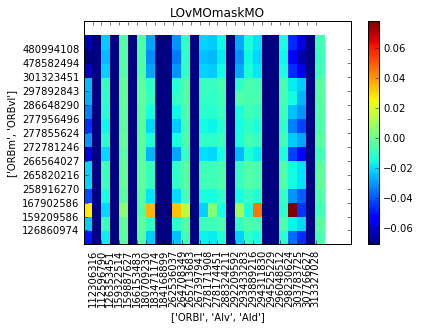

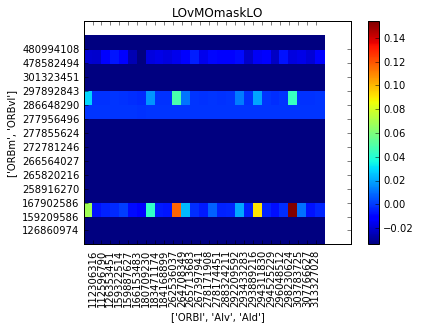

ok
Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', name=u'structure_id', length=643)


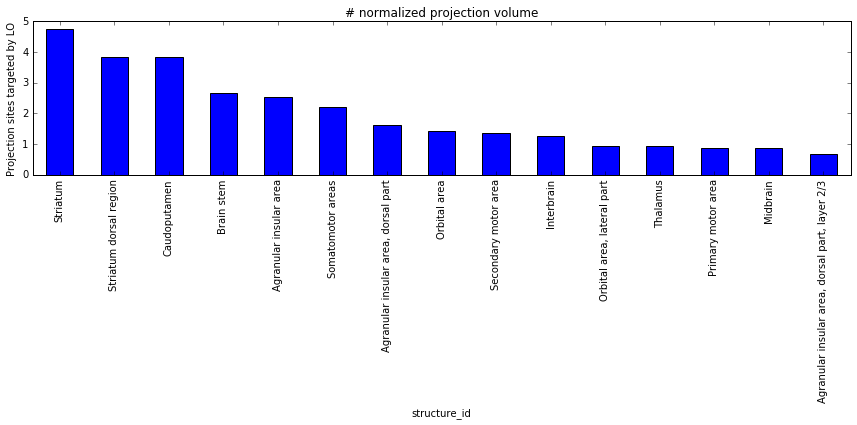

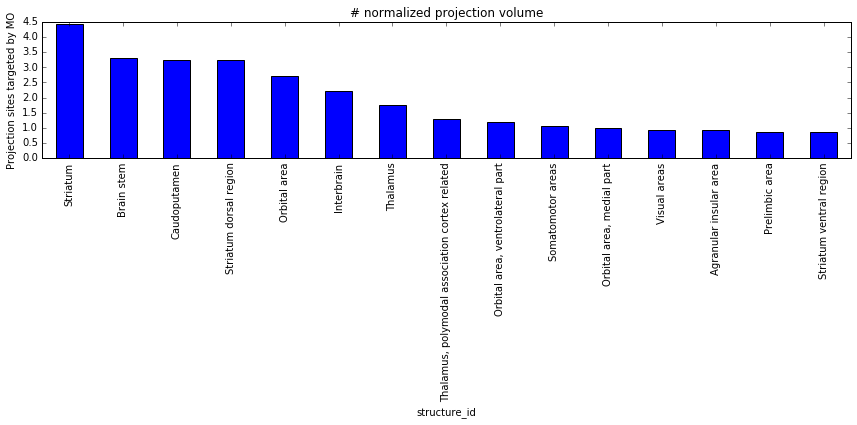

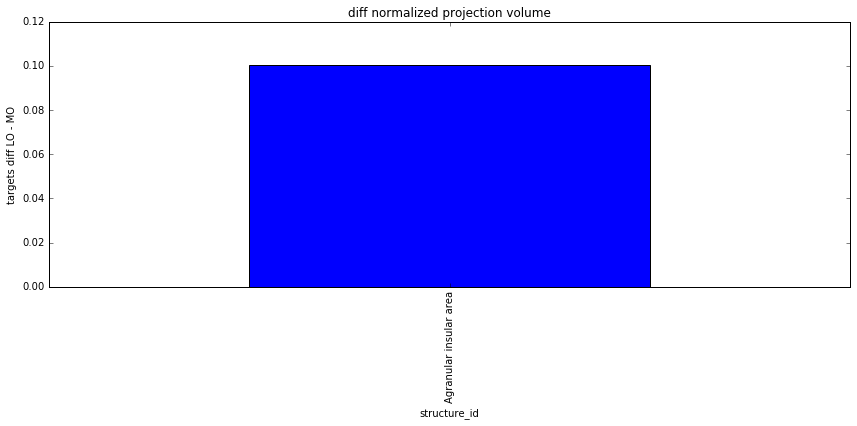

In [27]:
run_all(settings)

In [28]:
# #to debug
# mcc,all_experiments = get_data()
# ontology,names,grey=get_ont(mcc)
# name_d,ac_d = make_dict(names)
# for setting in settings:
#     regions,bad_vol,corr_max,diff_thresh = get_params(setting)
#     regions = get_your_experiments(regions,ontology,mcc)
#     # #make_table_by_region(regions) #turn on if i want to visualize
#     regions = make_table_by_proportion_in(regions,mcc,ontology,ac_d,bad_vol)
#     regions = get_brain_masks(regions,mcc,ontology)
#     mask_area = get_masks(regions,mcc)
#     Dict4 = get_corr(mask_area)
#     regionsc,mask_areac,Dict4c =make_backups(regions,mask_area,Dict4)
#     #check that this worked
#     for i in Dict4.itervalues():
#         print("average overlap is",np.mean(np.mean(i)))
#     plot_heat(Dict4,regions)
#     #df_arr.to_pickle('random_df.pkl')
#     Dict4,regions = filter_expts(Dict4,regions,corr_max)

In [30]:
#if I want to restore variables
#regions,mask_area,Dict4,regionsc,mask_areac,Dict4c = restore_backups(regionsc,mask_areac,Dict4c)